# Horizontal access

This notebook tests the developement of the `CurveCWSFourier` class, and the related objective and penalty functions to optimize a vertical access port to the device.

In [1]:
from simsopt._core import load
from simsopt.geo import SurfaceRZFourier
from simsopt.geo import VerticalPortDiscrete

import matplotlib.pyplot as plt
import numpy as np
import jax.numpy as jnp


import matplotlib 

%matplotlib widget

In [3]:
# Load the surface, assumed fixed in this notebook. 
surf = SurfaceRZFourier.from_vmec_input( '../configurations/qh_landreman_paul/input.scaled' )

nfp = surf.nfp
qpts_phi = np.linspace(0, 1/(2*nfp), 16)
qpts_theta = np.linspace(0, 1, 32)

vessel = SurfaceRZFourier(
    nfp = surf.nfp,
    mpol = surf.mpol,
    ntor = surf.ntor,
    stellsym = surf.stellsym,
    quadpoints_phi=qpts_phi,
    quadpoints_theta=qpts_theta,
    dofs = surf.dofs
)

bs = load( '../configurations/qh_landreman_paul/wiedman_coils/coils.wiedman.json' )
ncoils = 5
curves = [c.curve for c in bs.coils[0:2*ncoils] + bs.coils[-ncoils:]]


Text(0, 0.5, 'y')

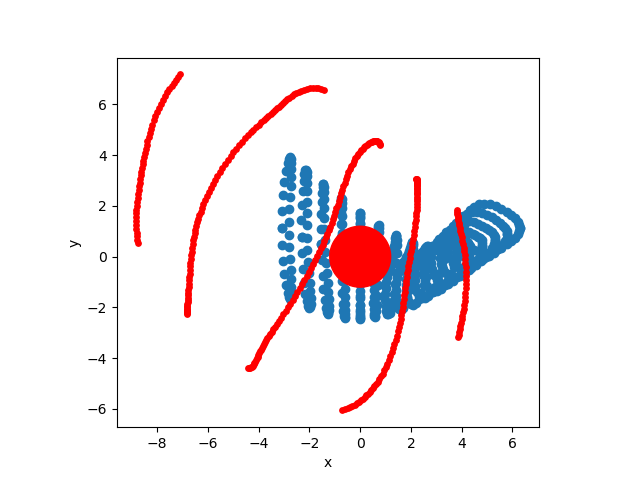

In [4]:
def project(x, x0):
    phic = jnp.arctan2(x0[1], x0[0])
    unit_normal = jnp.array([jnp.cos(phic), jnp.sin(phic), jnp.zeros(phic.shape)])
    unit_tangent = jnp.array([-jnp.sin(phic), jnp.cos(phic), jnp.zeros(phic.shape)])
    unit_z = jnp.array([jnp.zeros(phic.shape),jnp.zeros(phic.shape),jnp.ones(phic.shape)])

    M = jnp.array([unit_normal,unit_tangent,unit_z]).transpose()
    invM = jnp.linalg.inv(M)
    
    return jnp.einsum('ij,...j->...i',invM,x-x0)

iphi = 4
itheta = 0
x0 = vessel.gamma()[iphi,itheta,:]

gproj = project(vessel.gamma().reshape((-1,3)), x0)

fig, ax = plt.subplots()
ax.scatter(gproj[:,1],gproj[:,2])

rport = 1.2
l = np.linspace(0,2*np.pi,128,endpoint=True)
ax.fill(rport*np.cos(l), rport*np.sin(l), color='r')

for c in curves:
    g = project(c.gamma(), x0)
    zcurves = g[:,0]

    ind = np.where( zcurves>0 )[0]
    g = g[ind,:]

    ax.scatter(g[:,1], g[:,2], color='r', marker='o', s=15)

ax.set_aspect('equal')
ax.set_xlabel('x')
ax.set_ylabel('y')


## CurveCWSFourier

This class represents a curve that lies on a surface. 

In [5]:
from simsopt.geo import CurveCWSFourier, Curve2D

In [6]:
order = 2
qpts = 128
c2d = Curve2D(
    qpts, order
)
curve_cws = CurveCWSFourier(
    c2d,
    vessel
)

curve_cws.curve2d.set('phic(0)', 0.01)
curve_cws.curve2d.set('phic(1)', 0.01)
curve_cws.curve2d.set('thetac(0)', -0.1)
curve_cws.curve2d.set('thetas(1)', 0.2)
#curve_cws.set('thetas(2)', -0.15)

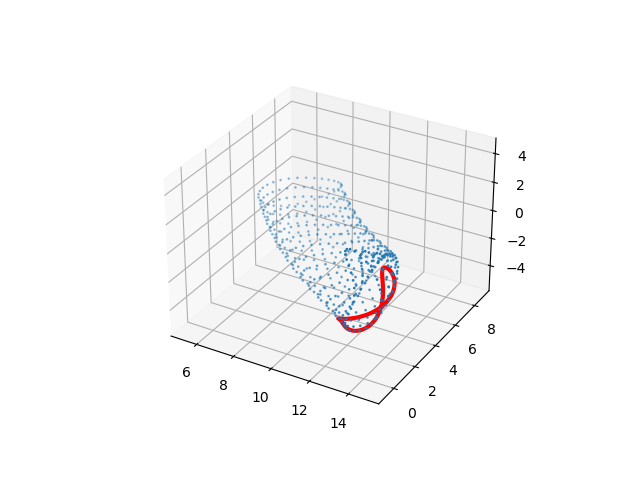

<Axes3D: >

In [8]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
g = vessel.gamma()
ax.scatter(g[...,0],g[...,1],g[...,2],s=1)
ax=plt.gca()
curve_cws.plot(ax=ax,color='r',linewidth=3)

Text(0, 0.5, 'y')

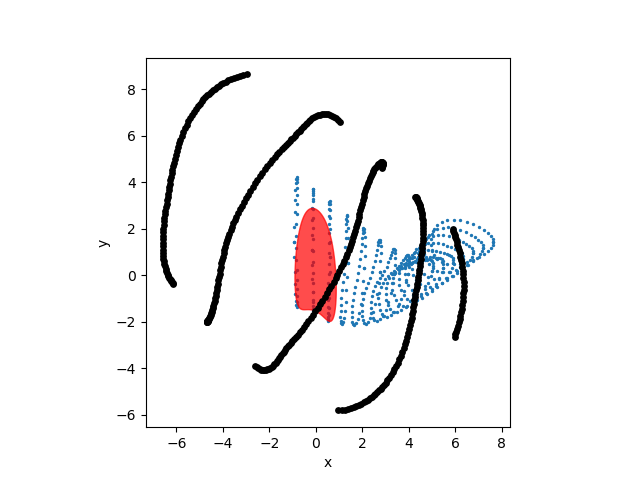

In [11]:
x0 = np.mean(curve_cws.gamma(), axis=0)

gproj = project(vessel.gamma().reshape((-1,3)), x0)

fig, ax = plt.subplots()
ax.scatter(gproj[:,1],gproj[:,2],s=2)

gport = project(curve_cws.gamma(), x0)
ax.fill(gport[:,1], gport[:,2], color='r', alpha=0.7)

for c in curves:
    g = project(c.gamma(), x0)
    zcurves = g[:,0]

    ind = np.where( zcurves>0 )[0]
    g = g[ind,:]

    ax.scatter(g[:,1], g[:,2], color='k', marker='o', s=15)

ax.set_aspect('equal')
ax.set_xlabel('x')
ax.set_ylabel('y')


# Objectives


In [8]:
from simsopt.geo import ProjectedEnclosedArea, ProjectedCurveCurveDistance, ProjectedCurveConvexity, DirectedFacingPort

## ProjectedEnclosedArea

As the name suggests, this is an objective for the area spanned by the curve projected on a plane.

In [9]:
Jarea = ProjectedEnclosedArea( curve_cws, projection='zphi' )

In [10]:
Jarea.J()

Array(3.35164206, dtype=float64)

Text(0.5, 0, '$\\epsilon$')

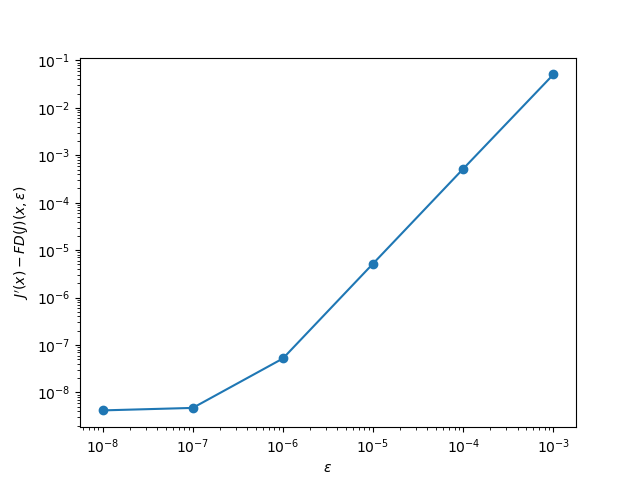

In [11]:
def f(x):
    Jarea.x = x
    return Jarea.J(), Jarea.dJ()

dofs = Jarea.x
np.random.seed(1)
h = np.random.uniform(size=dofs.shape)
J0, dJ0 = f(dofs)
dJh = sum(dJ0 * h)
myeps = [1e-3, 1e-4, 1e-5, 1e-6, 1e-7,1e-8]
myerr=[]
for eps in myeps:
    J1, _ = f(dofs + eps*h)
    J2, _ = f(dofs - eps*h)
    myerr.append( (J1-J2)/(2*eps) - dJh )

plt.figure()
plt.loglog(myeps, np.abs(myerr), marker='o')
plt.ylabel(r"$J'(x)-FD(J)(x,\epsilon)$")
plt.xlabel(r"$\epsilon$")

## ProjectedCurveCurveDistance

This penalty penalises curves that are too close to the port boundary once projected on a plane. This is heavily inspired from the implementation of `CurveCurveDistance`, excepted that here, only the distance to `curve_cws` is taken into account, the distance is in a plane, and only points that have a component normal to the plane higher than the curve_cws component are accounted for (this effectively removes curve elements behind the plasma)

In [12]:
Jccxydist = ProjectedCurveCurveDistance( curves, curve_cws, .1, projection='zphi' )

In [13]:
for c in curves:
    c.unfix_all()
vessel.fix_all()

In [14]:
Jccxydist.J()

Array(1.78534258, dtype=float64)

Text(0.5, 0, '$\\epsilon$')

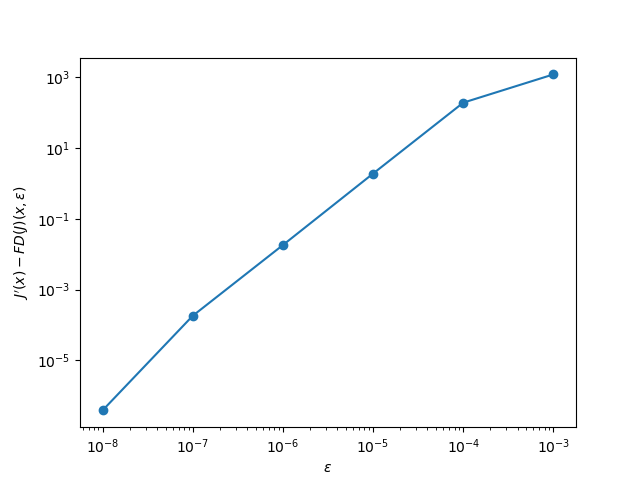

In [15]:
def f(x):
    Jccxydist.x = x
    return Jccxydist.J(), Jccxydist.dJ()

dofs = Jccxydist.x
np.random.seed(1)
h = np.random.uniform(size=dofs.shape)
J0, dJ0 = f(dofs)
dJh = sum(dJ0 * h)
myeps = [1e-3, 1e-4, 1e-5, 1e-6, 1e-7,1e-8]
myerr=[]
for eps in myeps:
    J1, _ = f(dofs + eps*h)
    J2, _ = f(dofs - eps*h)
    myerr.append( (J1-J2)/(2*eps) - dJh )

plt.figure()
plt.loglog(myeps, np.abs(myerr), marker='o')
plt.ylabel(r"$J'(x)-FD(J)(x,\epsilon)$")
plt.xlabel(r"$\epsilon$")

# Directed facing port

In [16]:
Jufp = DirectedFacingPort(curve_cws, projection='r')
Jufp.J()

Array(10.75651332, dtype=float64)

Text(0.5, 0, '$\\epsilon$')

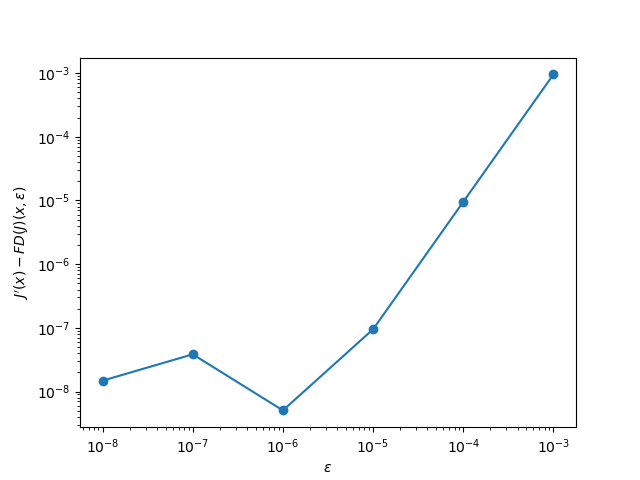

In [17]:
def f(x):
    Jufp.x = x
    return Jufp.J(), Jufp.dJ()

dofs = Jufp.x
np.random.seed(1)
h = np.random.uniform(size=dofs.shape)
J0, dJ0 = f(dofs)
dJh = sum(dJ0 * h)
myeps = [1e-3, 1e-4, 1e-5, 1e-6, 1e-7,1e-8]
myerr=[]
for eps in myeps:
    J1, _ = f(dofs + eps*h)
    J2, _ = f(dofs - eps*h)
    myerr.append( (J1-J2)/(2*eps) - dJh )

plt.figure()
plt.loglog(myeps, np.abs(myerr), marker='o')
plt.ylabel(r"$J'(x)-FD(J)(x,\epsilon)$")
plt.xlabel(r"$\epsilon$")

# Projected Curve Convexity

In [18]:
Jco = ProjectedCurveConvexity(curve_cws, projection='zphi')
Jco.J()

Array(1.47339582, dtype=float64)

Text(0.5, 0, '$\\epsilon$')

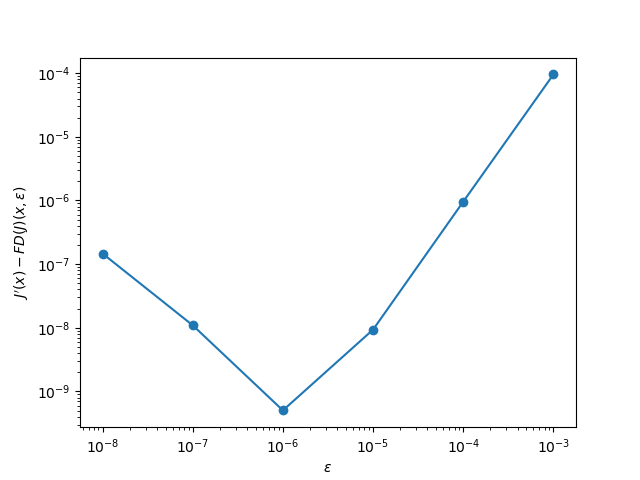

In [19]:
def f(x):
    Jco.x = x
    return Jco.J(), Jco.dJ()

dofs = Jco.x
np.random.seed(1)
h = np.random.uniform(size=dofs.shape)
J0, dJ0 = f(dofs)
dJh = sum(dJ0 * h)
myeps = [1e-3, 1e-4, 1e-5, 1e-6, 1e-7,1e-8]
myerr=[]
for eps in myeps:
    J1, _ = f(dofs + eps*h)
    J2, _ = f(dofs - eps*h)
    myerr.append( (J1-J2)/(2*eps) - dJh )

plt.figure()
plt.loglog(myeps, np.abs(myerr), marker='o')
plt.ylabel(r"$J'(x)-FD(J)(x,\epsilon)$")
plt.xlabel(r"$\epsilon$")

# Test optimization

We now perform a very simple optimization of the port size. The target function is 
$$
J = A_{xy}(C_0) + J_{cc\_dist}(C_0,\mathbf{C}) + J_{arclength}(C_0),
$$
where $C_0$ is the port boundary, and $\mathbf{C}$ is an array containing all the coils. We fix the boundary dofs and the coils dofs, only the port boundary is a free parameter. We initialize the port close to where the maximum port size was found using the vertical port discrete class.

In [20]:
from scipy.optimize import minimize
from simsopt.geo import ArclengthVariation
from simsopt.objectives import Weight

Text(0, 0.5, 'y')

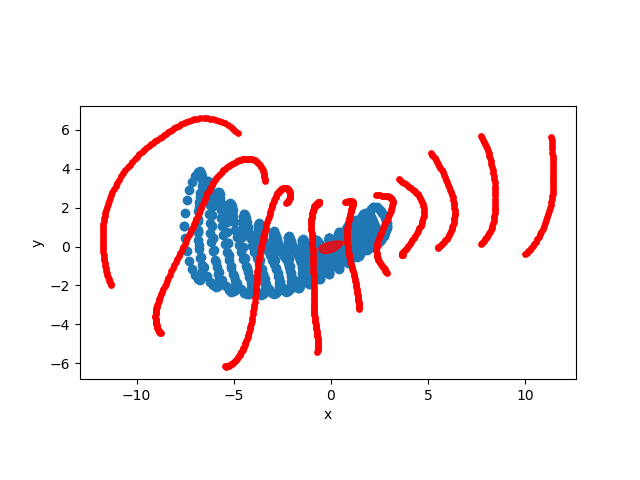

In [23]:
order = 6
qpts = 128
c2d = Curve2D( qpts, order )
curve_cws = CurveCWSFourier(
    c2d,
    vessel
)
vessel.fix_all()

curve_cws.curve2d.set('phic(0)', 0.085)
curve_cws.curve2d.set('phic(1)', 0.008)
curve_cws.curve2d.set('thetac(0)', 0.0)
curve_cws.curve2d.set('thetas(1)', 0.05)
dofs0 = curve_cws.x

x0 = np.mean(curve_cws.gamma(),axis=0)

gproj = project(vessel.gamma().reshape((-1,3)), x0)

fig, ax = plt.subplots()
ax.scatter(gproj[:,1],gproj[:,2])

gport = project(curve_cws.gamma(), x0)
ax.fill(gport[:,1], gport[:,2], color='r', alpha=.8)

for c in curves:
    g = project(c.gamma(), x0)
    zcurves = g[:,0]

    ind = np.where( zcurves>0 )[0]
    g = g[ind,:]

    ax.scatter(g[:,1], g[:,2], color='r', marker='o', s=15)

ax.set_aspect('equal')
ax.set_xlabel('x')
ax.set_ylabel('y')

In [22]:
# Define the objective function
bs = load( 'coils.wiedman.json' )
ncoils = 5
curves = [c.curve for c in bs.coils[0:2*ncoils] + bs.coils[-ncoils:]]
full_curves = [c.curve for c in bs.coils]


wdd = Weight(1E-2)
warc = Weight(1E-4)
wufp = Weight(1E-2)

Jxyarea = ProjectedEnclosedArea( curve_cws, projection='zphi' )
Jccxydist = ProjectedCurveCurveDistance( curves, curve_cws, 0.25, projection='zphi' )
Jconvex = ProjectedCurveConvexity( curve_cws, projection='zphi' )
Jarc = ArclengthVariation( curve_cws )
Jufp = DirectedFacingPort(curve_cws, projection='r')


J = -1*Jxyarea + wdd * Jccxydist + warc * Jarc + wufp*Jufp #+ wco * Jconvex  #+ wph * (Jphimin + Jphimax) + wco * Jconvex # #

def f(x, info={'Nfeval': 0}):
    info['Nfeval'] += 1
    
    J.x = x

    #A = Jxyarea.J()
    #CC = Jccxydist.J()
    #convex = Jconvex.J()
    out = J.J()
    
    #nf = info['Nfeval']
    #outstr = f"Nfeval: {nf}::  J={out:.2E}, Area={A:.2E}, Coil-coil dist={CC:.2E}, Convex={convex:.2E}, Arclength={Jarc.J():.2E}, Jufp={Jufp.J():.2E}"
    #if np.mod(nf,10)==0:
    #    outstr+="/n"
    #print(outstr)
    
    return out, J.dJ()

In [23]:
from simsopt.geo.curve import curves_to_vtk
from simsopt.field.coil import apply_symmetries_to_curves
from pystellplot.Paraview import coils_to_vtk, surf_to_vtk

curves_to_vtk(full_curves, 'visualization/modular_coils')

ports =  apply_symmetries_to_curves( [curve_cws], surf.nfp, False )
curves_to_vtk(ports, 'visualization/ports')
surf_to_vtk( "visualization/surface", bs, surf )

In [24]:
Jxyarea.J()

Array(1.47529706, dtype=float64)

In [25]:
Jccxydist.J()

Array(0., dtype=float64)

In [26]:
Jconvex.J()

Array(0.31833451, dtype=float64)

In [27]:
Jarc.J()

0.7917432674313274

In [28]:
Jufp.J()

Array(0., dtype=float64)

In [29]:
for c in curves:
    c.fix_all()
curve_cws.unfix_all()
vessel.fix_all()

dofs = J.x
f(dofs, {'Nfeval':0})

(Array(-1.47521789, dtype=float64),
 array([ 2.95420929e+00, -1.43459049e+02,  4.24054704e+00,  2.79718610e+00,
        -8.68657166e-02, -3.85459585e-02, -2.10574323e-03, -5.62705256e+01,
         2.54260214e+00,  2.81017880e+00,  3.95947818e-02,  3.03929503e-02,
        -2.66372266e-03,  7.17321472e-02,  8.55058760e-02,  4.40906214e-02,
         9.50161845e-02,  7.23401900e-03,  1.73236205e-03, -7.26306579e-04,
         9.96292230e-01, -2.62521926e-01,  1.00746600e+00, -3.39886880e-03,
         9.53949383e-03,  2.82157818e-04]))

In [30]:
curve_cws.dof_names

['Curve2D2:phic(0)',
 'Curve2D2:phic(1)',
 'Curve2D2:phic(2)',
 'Curve2D2:phic(3)',
 'Curve2D2:phic(4)',
 'Curve2D2:phic(5)',
 'Curve2D2:phic(6)',
 'Curve2D2:phis(1)',
 'Curve2D2:phis(2)',
 'Curve2D2:phis(3)',
 'Curve2D2:phis(4)',
 'Curve2D2:phis(5)',
 'Curve2D2:phis(6)',
 'Curve2D2:thetac(0)',
 'Curve2D2:thetac(1)',
 'Curve2D2:thetac(2)',
 'Curve2D2:thetac(3)',
 'Curve2D2:thetac(4)',
 'Curve2D2:thetac(5)',
 'Curve2D2:thetac(6)',
 'Curve2D2:thetas(1)',
 'Curve2D2:thetas(2)',
 'Curve2D2:thetas(3)',
 'Curve2D2:thetas(4)',
 'Curve2D2:thetas(5)',
 'Curve2D2:thetas(6)']

In [31]:
satisfied = False


while not satisfied:
    #curve_cws.x = dofs0
    print(f'Running with wdd={wdd.value:.2E}, warc={warc.value:.2E}, wufp={wufp.value:.2E}')
    MAXITER = 1E2
    dofs = dofs0
    print(dofs)
    res = minimize(f, dofs, jac=True, args=({'Nfeval': 0}), method='BFGS', options={'maxiter': MAXITER, 'maxcor': 300}, tol=1e-12)

    satisfied = True

    cpdist = Jccxydist.J()
    arcpen = Jarc.J()
    ufppen = Jufp.J()
    print(f'cpdist={cpdist:.2E}, arcpen={arcpen:.2E}, ufp={ufppen:.2E}')
    if cpdist>1E-6:
        print('cpdist too large')
        wdd *= 1.5
        satisfied = False

    elif arcpen>1:
        print('arcpen too large')
        warc *= 1.5
        satisfied = False

    elif ufppen>= 0.01:
        print('ufppen too large')
        wufp *= 1.5
        satisfied = False

    

Running with wdd=1.00E-02, warc=1.00E-04, wufp=1.00E-02
[0.004 0.01  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.05  0.    0.    0.
 0.    0.   ]


/var/folders/2t/kl_73rbx6v5g_wjy89yslg7r0000gn/T/ipykernel_2937/3100075601.py:10: OptimizeWarning: Unknown solver options: maxcor
  res = minimize(f, dofs, jac=True, args=({'Nfeval': 0}), method='BFGS', options={'maxiter': MAXITER, 'maxcor': 300}, tol=1e-12)


cpdist=1.03E+01, arcpen=1.55E+00, ufp=2.72E+00
cpdist too large
Running with wdd=1.50E-02, warc=1.00E-04, wufp=1.00E-02
[0.004 0.01  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.05  0.    0.    0.
 0.    0.   ]
cpdist=1.57E+01, arcpen=1.76E+00, ufp=9.09E+00
cpdist too large
Running with wdd=2.25E-02, warc=1.00E-04, wufp=1.00E-02
[0.004 0.01  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.05  0.    0.    0.
 0.    0.   ]
cpdist=1.78E+01, arcpen=1.78E+00, ufp=2.51E+00
cpdist too large
Running with wdd=3.38E-02, warc=1.00E-04, wufp=1.00E-02
[0.004 0.01  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.05  0.    0.    0.
 0.    0.   ]
cpdist=5.73E+00, arcpen=2.05E+00, ufp=0.00E+00
cpdist too large
Running with wdd=5.06E-02, warc=1.00E-04, wufp=1.00E-02
[0.004 0.01  0.    0.    0.    0.    0.    0.    0.    0. 

/var/folders/2t/kl_73rbx6v5g_wjy89yslg7r0000gn/T/ipykernel_2937/3100075601.py:10: OptimizeWarning: Unknown solver options: maxcor
  res = minimize(f, dofs, jac=True, args=({'Nfeval': 0}), method='BFGS', options={'maxiter': MAXITER, 'maxcor': 300}, tol=1e-12)


cpdist=8.34E-01, arcpen=1.34E+00, ufp=0.00E+00
cpdist too large
Running with wdd=1.71E-01, warc=1.00E-04, wufp=1.00E-02
[0.004 0.01  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.05  0.    0.    0.
 0.    0.   ]


/var/folders/2t/kl_73rbx6v5g_wjy89yslg7r0000gn/T/ipykernel_2937/3100075601.py:10: OptimizeWarning: Unknown solver options: maxcor
  res = minimize(f, dofs, jac=True, args=({'Nfeval': 0}), method='BFGS', options={'maxiter': MAXITER, 'maxcor': 300}, tol=1e-12)


cpdist=5.26E-01, arcpen=6.40E-01, ufp=2.06E+00
cpdist too large
Running with wdd=2.56E-01, warc=1.00E-04, wufp=1.00E-02
[0.004 0.01  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.05  0.    0.    0.
 0.    0.   ]
cpdist=3.30E-01, arcpen=5.54E-01, ufp=1.24E-01
cpdist too large
Running with wdd=3.84E-01, warc=1.00E-04, wufp=1.00E-02
[0.004 0.01  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.05  0.    0.    0.
 0.    0.   ]
cpdist=2.67E-01, arcpen=5.82E-01, ufp=8.36E-01
cpdist too large
Running with wdd=5.77E-01, warc=1.00E-04, wufp=1.00E-02
[0.004 0.01  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.05  0.    0.    0.
 0.    0.   ]
cpdist=1.19E-02, arcpen=9.93E-01, ufp=1.50E+01
cpdist too large
Running with wdd=8.65E-01, warc=1.00E-04, wufp=1.00E-02
[0.004 0.01  0.    0.    0.    0.    0.    0.    0.    0. 

In [32]:
res.message

'Maximum number of iterations has been exceeded.'

In [33]:
MAXITER = 1E4
res = minimize(f, dofs, jac=True, args=({'Nfeval': 0}), method='BFGS', options={'maxiter': MAXITER, 'maxcor': 300}, tol=1e-12)
print(res.message)

if cpdist>1E-6:
    print('cpdist too large')

elif arcpen>1:
    print('arcpen too large')

elif ufppen>= 0.01:
    print('ufppen too large')

/var/folders/2t/kl_73rbx6v5g_wjy89yslg7r0000gn/T/ipykernel_2937/1207016871.py:2: OptimizeWarning: Unknown solver options: maxcor
  res = minimize(f, dofs, jac=True, args=({'Nfeval': 0}), method='BFGS', options={'maxiter': MAXITER, 'maxcor': 300}, tol=1e-12)


Desired error not necessarily achieved due to precision loss.


In [12]:
import os
os.makedirs(exi

In [34]:
print(np.max(np.abs(J.dJ())))

4.894943709898847e-05


In [35]:
#Jxyarea + wdd * Jccxydist + warc * Jarc + wufp*Jufp
Jufp.dJ()

array([  4.19832466, -11.83865671,  -0.21288629,  25.32891239,
        -5.00729262, -18.99487545,   0.75805857,  28.49478552,
        -4.08974546,  -9.90974654,  -0.45827912,  -9.8015042 ,
         9.13749697,   3.00501183,  -8.52885404,  -0.1202815 ,
        18.22295567,  -3.65308771, -13.60578683,   0.56951462,
        20.4541267 ,  -2.95056905,  -7.04773269,  -0.35013116,
        -7.13516357,   6.62662933])

Text(0.5, 0, '$\\epsilon$')

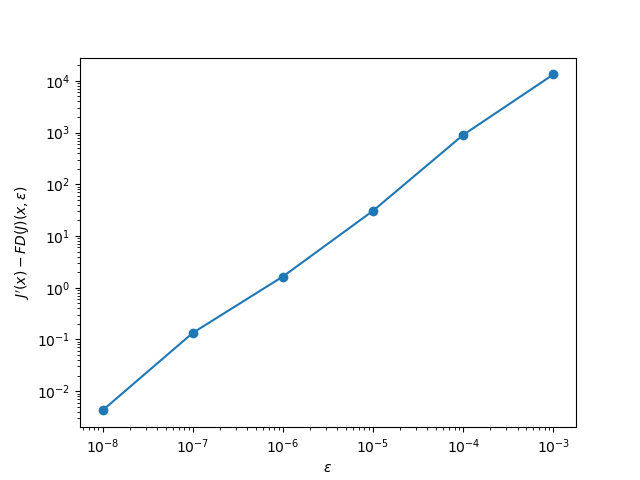

In [36]:
JJ = Jccxydist #Jarc #Jufp

def f(x):
    JJ.x = x
    return JJ.J(), JJ.dJ()

dofs = JJ.x
np.random.seed(1)
h = np.random.uniform(size=dofs.shape)
J0, dJ0 = f(dofs)
dJh = sum(dJ0 * h)
myeps = [1e-3, 1e-4, 1e-5, 1e-6, 1e-7,1e-8]
myerr=[]
for eps in myeps:
    J1, _ = f(dofs + eps*h)
    J2, _ = f(dofs - eps*h)
    myerr.append( (J1-J2)/(2*eps) - dJh )

plt.figure()
plt.loglog(myeps, np.abs(myerr), marker='o')
plt.ylabel(r"$J'(x)-FD(J)(x,\epsilon)$")
plt.xlabel(r"$\epsilon$")

In [37]:
Jccxydist.J()

Array(5.38865718e-10, dtype=float64)

In [38]:
Jxyarea.J()

Array(4.88061105, dtype=float64)

In [39]:
Jconvex.J()

Array(9.72664266, dtype=float64)

In [40]:
Jarc.J()

0.8309350474142445

In [41]:
Jufp.J()

Array(0.02736779, dtype=float64)

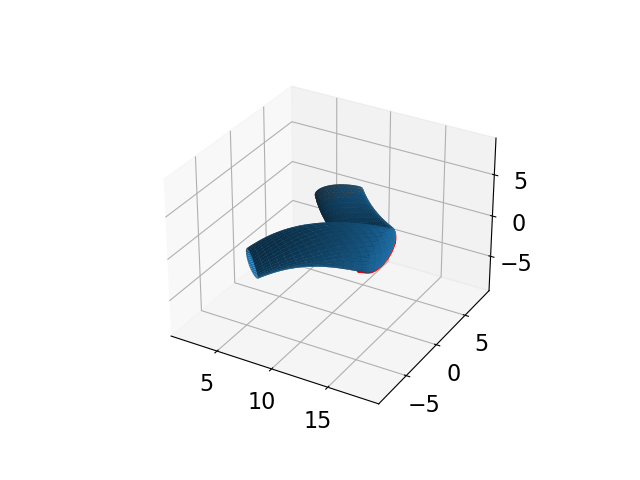

<Axes3D: >

In [227]:
nfp = vessel.nfp
qpts_theta = np.linspace(0,1,128)
qpts_phi = np.linspace(-1/(2*nfp), 1/(2*nfp), 64)
splot = SurfaceRZFourier(
    mpol = vessel.mpol,
    ntor = vessel.ntor,
    nfp = nfp,
    quadpoints_theta=qpts_theta,
    quadpoints_phi=qpts_phi,
    dofs = vessel.dofs
)


splot.plot(show=False)
vessel.plot(ax=plt.gca(),show=False)
curve_cws.plot(ax=plt.gca(), color='r')

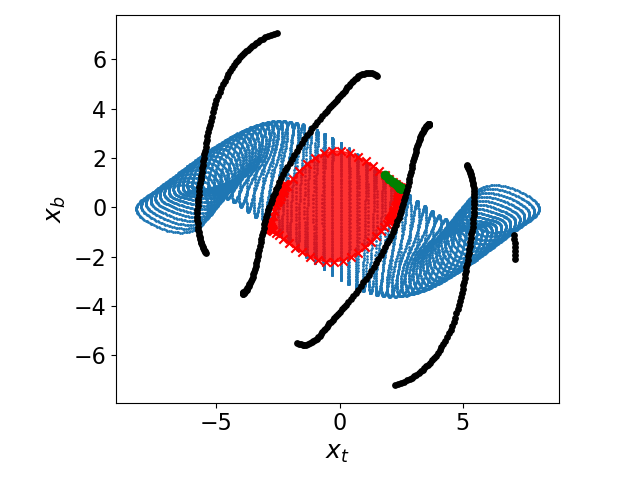

In [228]:
x0 = np.mean(curve_cws.gamma(),axis=0)


gproj = project(splot.gamma().reshape((-1,3)), x0)

fig, ax = plt.subplots()
ax.scatter(gproj[:,1],gproj[:,2],s=1)

gport = project(curve_cws.gamma(), x0)
ax.fill(gport[:,1], gport[:,2], color='r', alpha=.8)
ax.scatter(gport[:,1], gport[:,2], color='r', marker='x')

rf = curve_cws.rfactor()
ind = np.where(rf<0)
ax.scatter(gport[ind,1], gport[ind,2], color='g', marker='o')

for c in curves:
    g = project(c.gamma(), x0)
    zcurves = g[:,0]

    ind = np.where( zcurves>0 )[0]
    g = g[ind,:]

    ax.scatter(g[:,1], g[:,2], color='k', marker='o', s=15)

c = curves[0]
g = project(c.gamma(), x0)
zcurves = g[:,0]

ind = np.where( zcurves>0 )[0]
g = g[ind,:]



order = 2
qpts = 128
c2d = Curve2D( qpts, order )
original_curve_cws = CurveCWSFourier(
    c2d,
    vessel
)


# original_curve_cws.set('phic(0)', 0.0)
# original_curve_cws.set('phic(1)', 0.007)
# original_curve_cws.set('thetac(0)', 0.0)
# original_curve_cws.set('thetas(1)', 0.05)


# gport = project(original_curve_cws.gamma(), x0)
# ax.fill(gport[:,1], gport[:,2], color='g', alpha=.8)

#ax.scatter(g[:,1], g[:,2], color='g', marker='o', s=30)

matplotlib.rc('xtick', labelsize=16) 
matplotlib.rc('ytick', labelsize=16) 
ax.set_aspect('equal')
ax.set_xlabel(r'$x_t$', fontsize=18)
ax.set_ylabel(r'$x_b$', fontsize=18)
plt.tight_layout()

Great! This seems to work as expected. We can now try a stage II optimization, where we target a larger port size while keeping the field error small...

In [ ]:
curves_to_vtk(ports, 'visualization/ports_after_test')